# Objective : 
Classify the Amazon food reviews and determine whether it is positive or negative. 

## Workflow:
1. Sort data based on time.
2. Convert reviews of "Amazon Fine Food Review" dataset into vectors using Bag of words. 
3. Split data into train and test.
4. Find best hyperparameter by k-fold cross validation.
5. Apply k-NN model on the train data.
6. Find accuracy of the model.
7. Print confusion matrix and plot error plot. 

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, gensim
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Importing data

In [0]:
# Reading data from .sqlite file,choosing only positive and negative reviews not neutral reviews.
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

# changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


## Cleansing data

In [0]:
# removes duplicate data from dataset that are repeatedly mentioned.
# Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
# Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [0]:
# Sorting data on the basis of TIME
final = final[:30000]
final = final.sort_values(by=['Time'], axis=0)
final.shape

(30000, 10)

## Text preprocessing

In [0]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():# clean punctuation marks from words
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# verifying word must be a alphabet and atleat two character long
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):# blocks stopwords
                    s=(sno.stem(cleaned_words))# stemming in process
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [0]:
amazon_data_text = pd.Series(final_text)
amazon_data_label = pd.Series(final['Score'])
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(30000,)
(30000,)


In [0]:
#Spliting sample data into train_data and test_data (75:25)
x_train, x_test, y_train, y_test = cross_validation.train_test_split(\
                                                                     amazon_data_text,\
                                                                     amazon_data_label,\
                                                                     test_size = 0.25,\
                                                                     random_state=0)

In [0]:
print(y_test.value_counts())

positive    6355
negative    1145
Name: Score, dtype: int64


### Bag of words.

In [0]:
# Convert train data from text to vectors by BOW.
count_vect = CountVectorizer(analyzer='word') #in scikit-learn
bow_text_train_vector = count_vect.fit_transform(x_train)
bow_text_train_vector = bow_text_train_vector
bow_text_train_vector.shape

(22500, 20439)

In [0]:
# converts test data from text to vectors by BOW.
bow_text_test_vector = count_vect.transform(x_test)
bow_text_test_vector = bow_text_test_vector
print(bow_text_test_vector.shape)

(7500, 20439)



The optimal number of neighbors is 8.


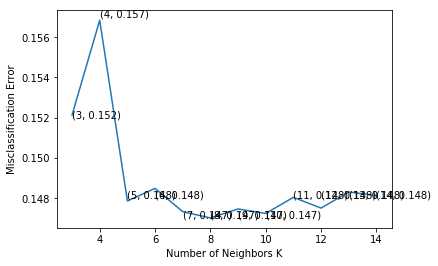

the misclassification error for each k value is :  [0.152 0.157 0.148 0.148 0.147 0.147 0.147 0.147 0.148 0.148 0.148 0.148]


In [0]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, bow_text_train_vector, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
bow_optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % bow_optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


The accuracy of the knn classifier for k = 8 is 85.066667%


Text(0.5,1,'CONFUSION MATRIX')

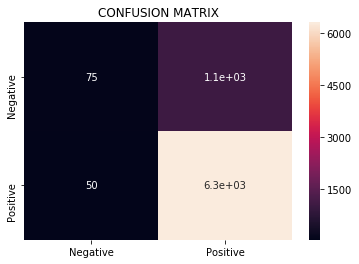

In [0]:
# apply k-NN(brute force)
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= bow_optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(bow_text_train_vector, y_train)
# response prediction
pred = knn_brute.predict(bow_text_test_vector)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (bow_optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix, ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier for k = 8 is 85.066667%


Text(0.5,1,'CONFUSION MATRIX')

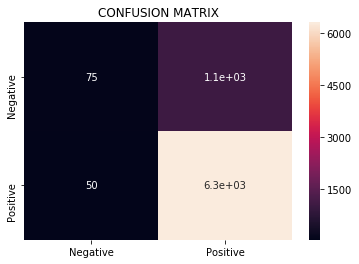

In [0]:
# Apply k-NN(kd tree)
# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= bow_optimal_k, algorithm = 'kd_tree')
# fitting the model
knn_brute.fit(bow_text_train_vector, y_train)
# response prediction
pred = knn_brute.predict(bow_text_test_vector)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (bow_optimal_k, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix, ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("CONFUSION MATRIX")

#### Observations :
* Applied Bag of words to convert text to vector.
* Hyperparameter for the k-NN model is 8.
* Got accuracy of 85.066667%.